# **Health Insurance Cross Sell Prediction**

I received this data from Kaggle. 

Leveraging data from a Health Insurance provider, I applied supervised learning algorithms to forecast whether previous year's policyholders might be interested in a newly offered Vehicle Insurance. The essence of insurance policies involves companies offering compensation for losses in return for a premium—a fixed payment from customers. For example, paying an annual health insurance premium of 500 dollars might secure a coverage of 200,000 dollars, based on the shared risk principle where premiums from many support the claims of a few.

This concept extends to vehicle insurance, where an annual premium ensures compensation for vehicular damages. By predicting interest in vehicle insurance, the aim is to enable the company to strategically plan its outreach, optimizing business efficiency and revenue. The model uses demographic, vehicle, and policy details to identify customers likely to be interested in vehicle insurance, demonstrating the practical application of machine learning techniques in enhancing business strategies.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib
import seaborn as sns
import holoviews as hv
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.utils import resample,shuffle
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from mlxtend.preprocessing import minmax_scaling
from sklearn.decomposition import PCA,SparsePCA,KernelPCA,NMF
from holoviews import opts
from sklearn import metrics, mixture, cluster, datasets
from sklearn.mixture import GaussianMixture
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score, roc_curve, auc

In [2]:
train_data = pd.read_csv("gs://supervised_learning_gagan/train.csv")
test_data = test = pd.read_csv("gs://supervised_learning_gagan/test.csv")

print(' Training data : Number of rows: '+ format(train_data.shape[0]) +', number of features: '+ format(train_data.shape[1]))
print(' Test data : Number of rows: '+ format(test_data.shape[0]) +', number of features: '+ format(test_data.shape[1]))

 Training data : Number of rows: 381109, number of features: 12
 Test data : Number of rows: 127037, number of features: 11


# **Exploratory data analysis**

In [3]:
print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
None


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
C = (train_data.dtypes == 'object')
CategoricalVariables = list(C[C].index)

Integer = (train_data.dtypes == 'int64') 
Float   = (train_data.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

Missing_Percentage = (train_data.isnull().sum()).sum()/np.product(train_data.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

The number of missing entries before cleaning: 0.0 %


We don't need to fix any NA values as there are none.

In [5]:
CategoricalVariables

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

Let's convert vehicle age to numeric variable.

In [6]:
train_data.Vehicle_Age.unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [7]:
Vehicle_Age_map  = {'< 1 Year':0,'1-2 Year':1,'> 2 Years':2}

train_data['Vehicle_Age'] = train_data['Vehicle_Age'].map(Vehicle_Age_map)
train_data=train_data.set_index("id")

C = (train_data.dtypes == 'object')
CategoricalVariables = list(C[C].index)

Integer = (train_data.dtypes == 'int64') 
Float   = (train_data.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

train_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,2,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,2,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,0,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,0,No,27496.0,152.0,39,0


In [8]:
def highlight_cols(s, coldict):
    if s.name in coldict.keys():
        return ['background-color: {}'.format(coldict[s.name])] * len(s)
    return [''] * len(s)

def ExtractColumn(lst,j): 
    return [item[j] for item in lst] 

In [9]:
coldict = {'Gender':'lightcoral','Age':'lightcoral', 'Driving_License':'lightsalmon', 'Region_Code':'lightsalmon', 'Previously_Insured':'lightsalmon'
           , 'Vehicle_Age':'lightsalmon', 'Vehicle_Damage':'lightsalmon', 'Annual_Premium':'lightsalmon', 'Policy_Sales_Channel':'tomato'
           ,'Vintage':'tomato','Response':'darksalmon'}
train_data.iloc[0:5].style.apply(highlight_cols, coldict=coldict)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.000000,0,2,Yes,40454.000000,26.000000,217,1
2,Male,76,1,3.000000,0,1,No,33536.000000,26.000000,183,0
3,Male,47,1,28.000000,0,2,Yes,38294.000000,26.000000,27,1
4,Male,21,1,11.000000,1,0,No,28619.000000,152.000000,203,0
5,Female,29,1,41.000000,1,0,No,27496.000000,152.000000,39,0


In [10]:
df_dummy = pd.get_dummies(train_data[CategoricalVariables], columns=CategoricalVariables)
df_numeric = train_data[NumericVariables]
df_final = pd.merge(df_numeric,df_dummy,on='id')

response = ['Response']
VariablesNoTarget = [x for x in df_final.columns if x not in response]
print("Dummy transformation was successful")

Dummy transformation was successful


In [11]:
coldict_dummy = {'Gender_Female':'lightcoral','Gender_Male':'lightcoral','Age':'lightcoral', 'Driving_License':'lightsalmon' 
                   ,'Region_Code':'lightsalmon', 'Previously_Insured':'lightsalmon'
                   , 'Vehicle_Age':'lightsalmon', 'Vehicle_Damage_No':'lightsalmon', 'Vehicle_Damage_Yes':'lightsalmon', 'Annual_Premium':'lightsalmon'
                   , 'Policy_Sales_Channel':'tomato','Vintage':'tomato','Response':'darksalmon'}

df_final = df_final[['Age','Gender_Female','Gender_Male','Driving_License','Previously_Insured','Vehicle_Age','Region_Code','Vehicle_Damage_No'
               ,'Vehicle_Damage_Yes','Annual_Premium','Policy_Sales_Channel','Vintage','Response']]

df_final[VariablesNoTarget] = minmax_scaling(df_final, columns=VariablesNoTarget)
df_final.iloc[0:5].style.apply(highlight_cols, coldict=coldict_dummy)

,Age,Gender_Female,Gender_Male,Driving_License,Previously_Insured,Vehicle_Age,Region_Code,Vehicle_Damage_No,Vehicle_Damage_Yes,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,,,
1,0.369231,0.000000,1.000000,1.000000,0.000000,1.000000,0.538462,0.000000,1.000000,0.070366,0.154321,0.716263,1
2,0.861538,0.000000,1.000000,1.000000,0.000000,0.500000,0.057692,1.000000,0.000000,0.057496,0.154321,0.598616,0
3,0.415385,0.000000,1.000000,1.000000,0.000000,1.000000,0.538462,0.000000,1.000000,0.066347,0.154321,0.058824,1
4,0.015385,0.000000,1.000000,1.000000,1.000000,0.000000,0.211538,1.000000,0.000000,0.048348,0.932099,0.667820,0
5,0.138462,1.000000,0.000000,1.000000,1.000000,0.000000,0.788462,1.000000,0.000000,0.046259,0.932099,0.100346,0


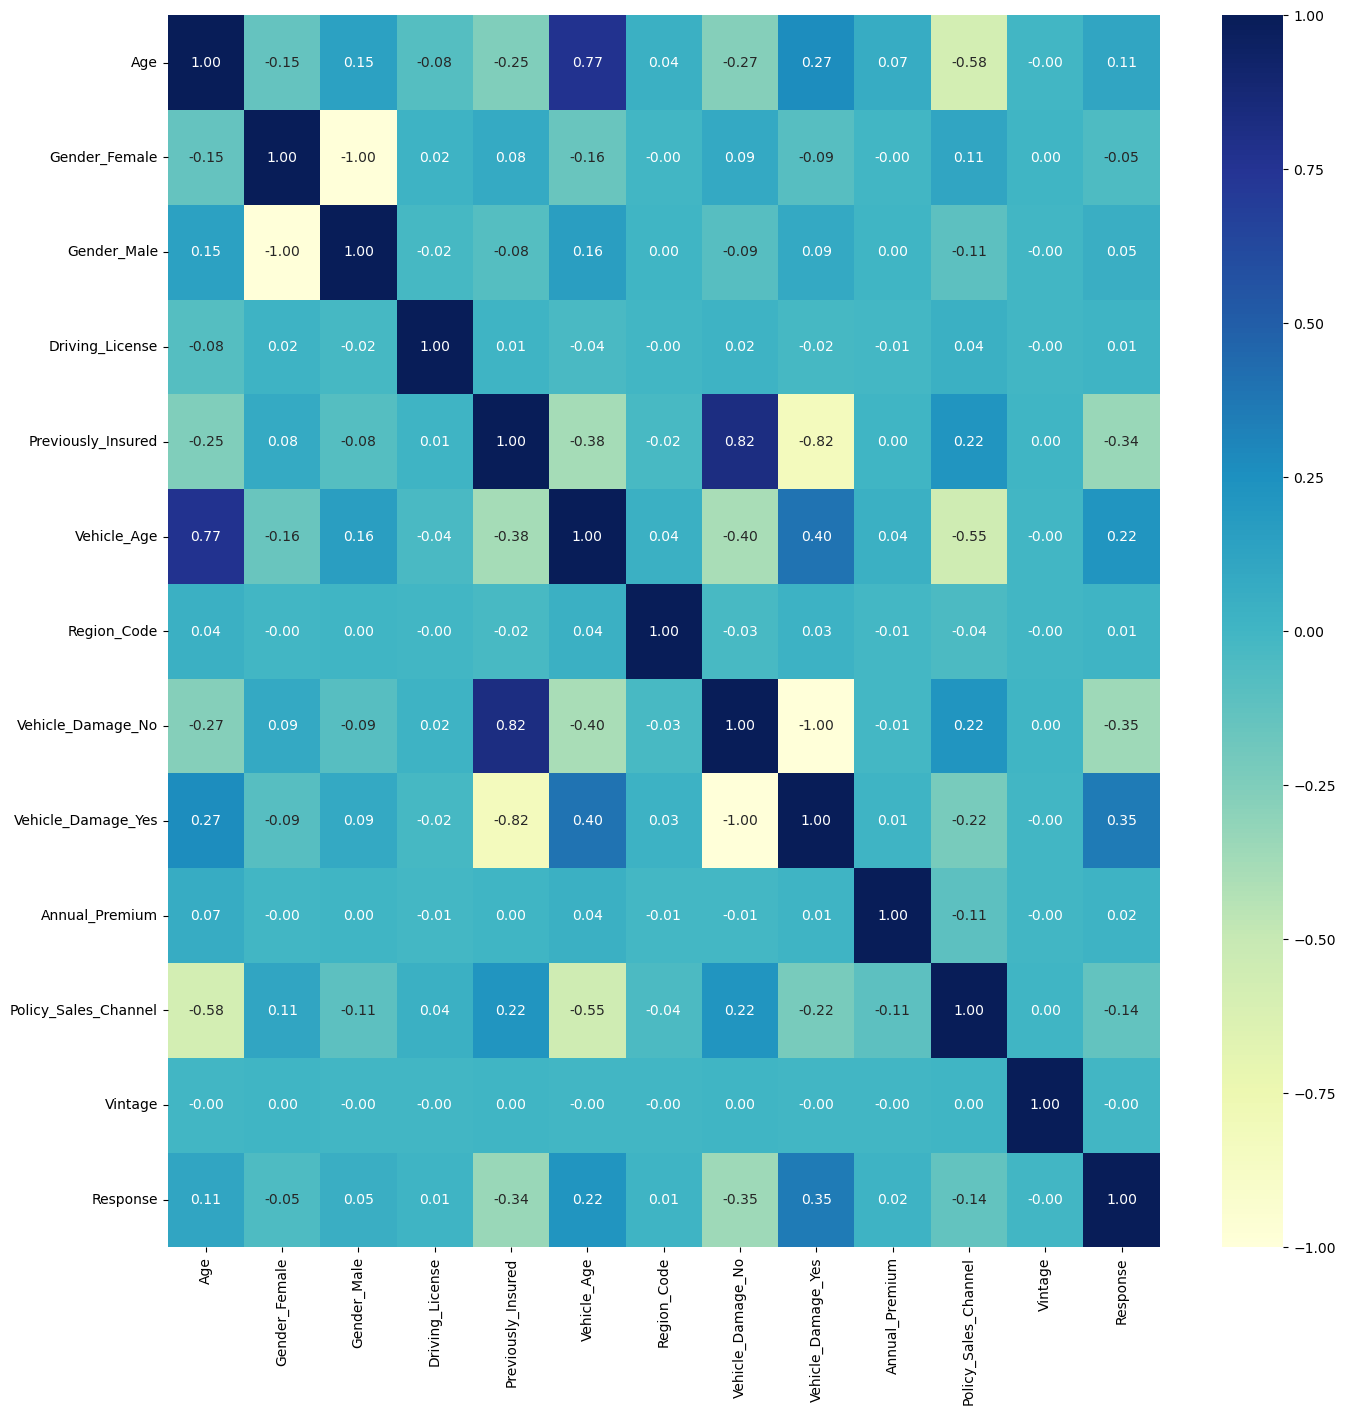

In [12]:
df_corr = df_final.corr()
f, ax = plt.subplots(figsize=(16, 16))
# sns.heatmap(df_corr, vmax=.8, square=True)
# plt.show()

sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='YlGnBu',annot_kws={'size': 10}, ax=ax)
plt.show()

There seems to be some correlation between response and vehicle_demage.

Age and vehicle age have strong correlation.

Previously insured is correlated with vehicle damage.


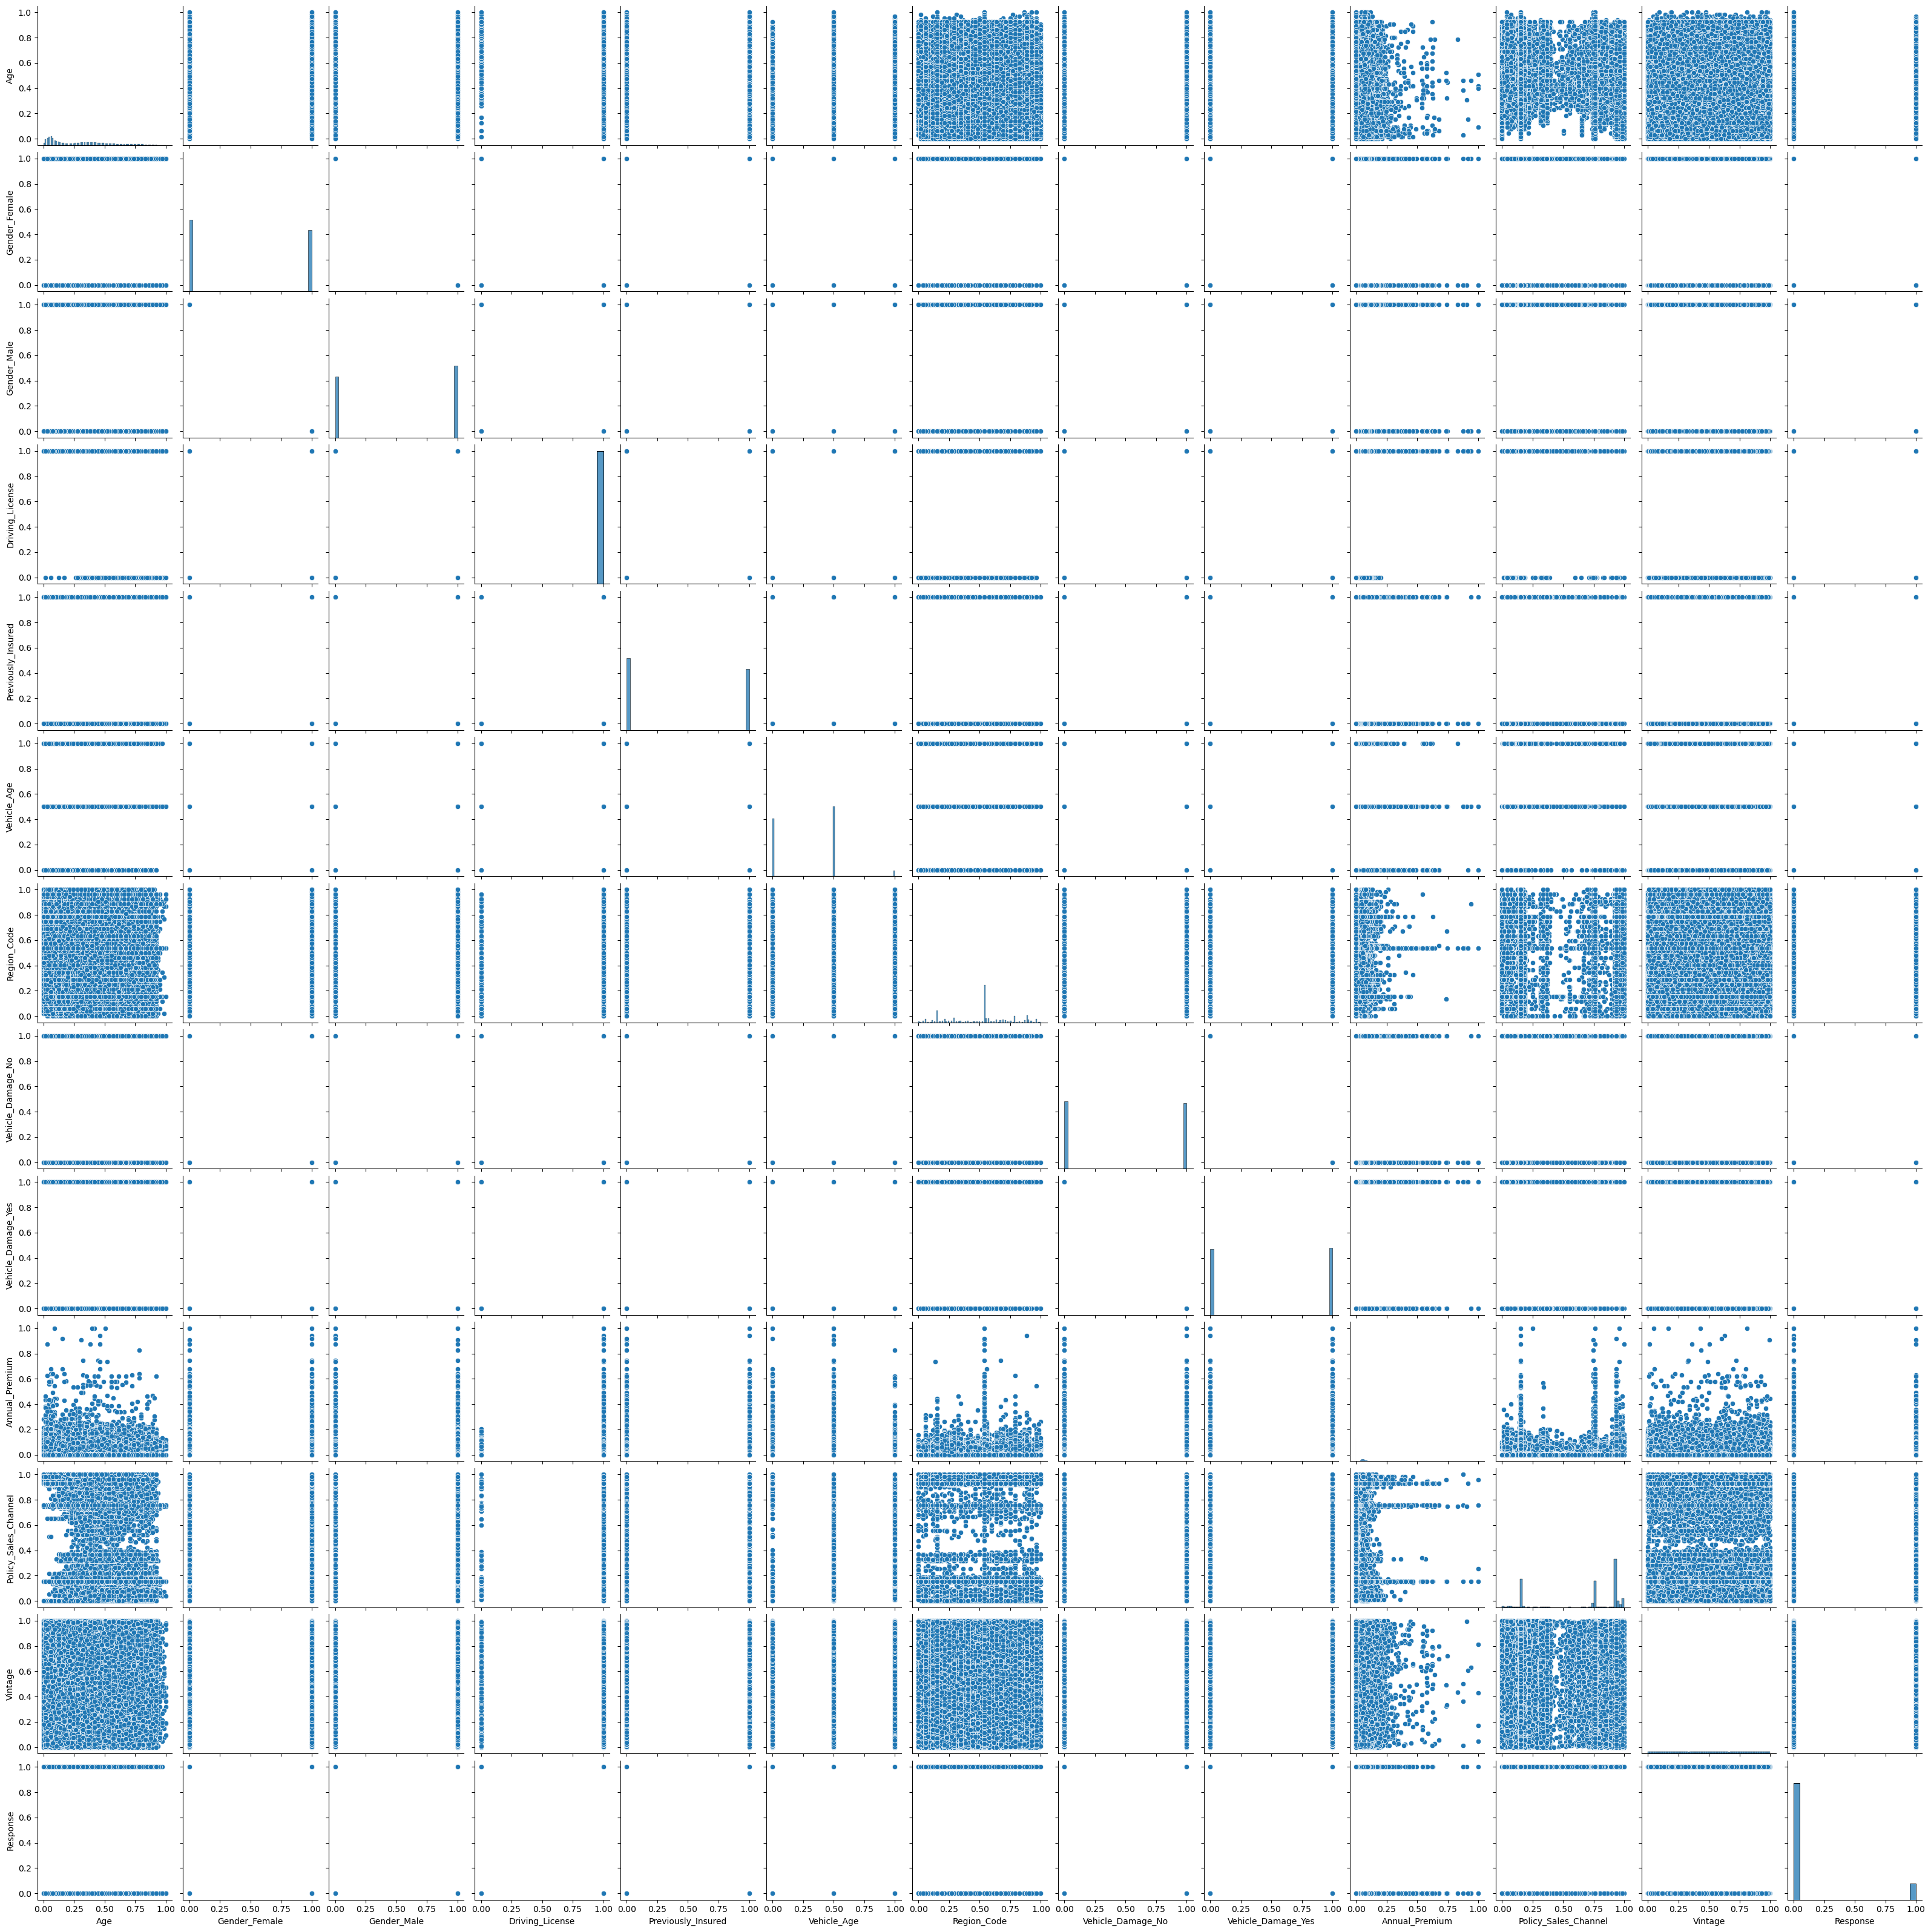

In [13]:
sns.pairplot(df_final)

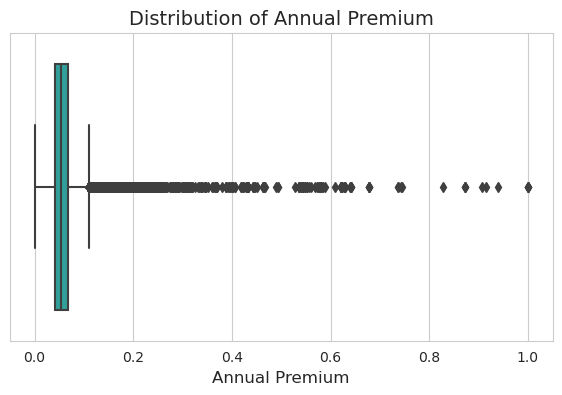

In [14]:
sns.set_style("whitegrid")
plt.figure(figsize=(7, 4))
sns.boxplot(x=df_final['Annual_Premium'], color="lightseagreen")
plt.title('Distribution of Annual Premium', fontsize=14)
plt.xlabel('Annual Premium', fontsize=12)
plt.ylabel('')
plt.yticks([])  
plt.show()


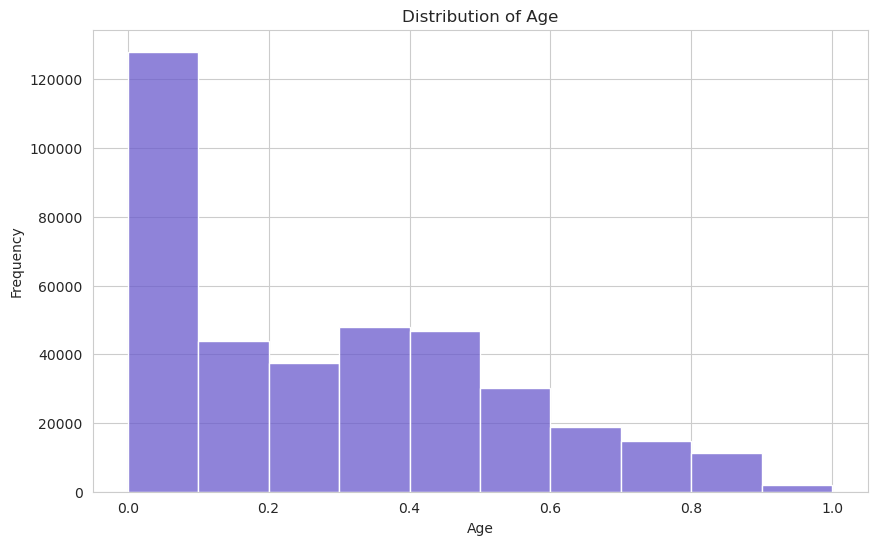

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['Age'], kde=False, bins=10, color="slateblue")
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

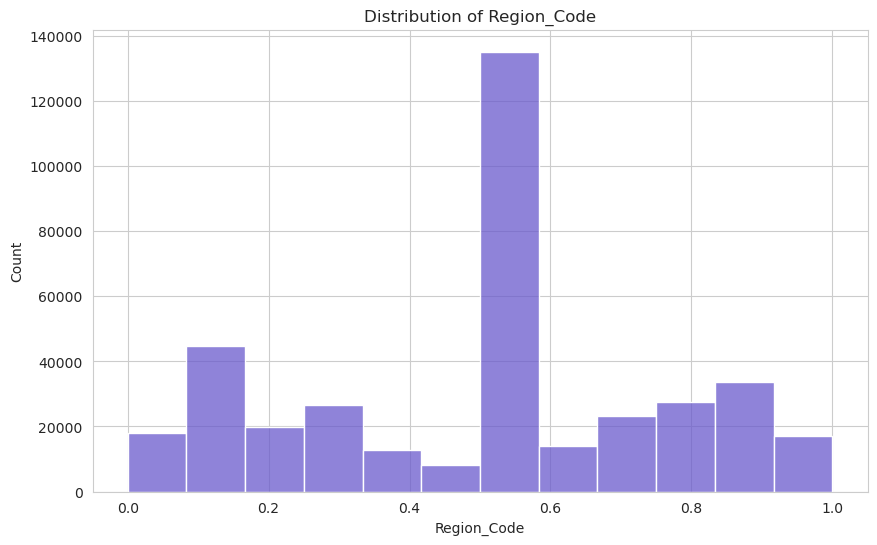

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final['Region_Code'], kde=False, bins=12, color="slateblue" )
plt.title('Distribution of Region_Code')
plt


<Figure size 600x600 with 0 Axes>

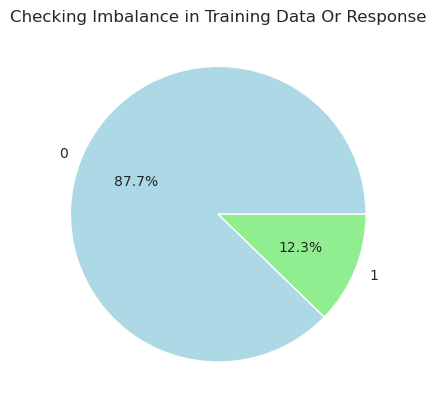

In [17]:
response_data = df_final['Response'].value_counts()
colors = ['lightblue', 'lightgreen']  
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
ax.pie(response_data, labels=[0, 1], colors=colors, autopct='%1.1f%%')  
ax.set_title('Checking Imbalance in Training Data Or Response')
plt.show()

**Applying Supervised Learning to the problem:**

**Logistic regression**


Let's first get the basic model estimation on the basis of mean value.

In [18]:
Target= df_final['Response']
df_final_ = df_final.drop(['Response'],axis=1)

x_train,x_test,y_train,y_test = train_test_split(df_final_,Target,test_size=0.2,random_state=0)

In [19]:
ModelAverage = y_train.mean()
print(str(round(ModelAverage,5)))

0.12245


So the benchmark is 12%. 12% of the customers are interested in buying the product.

In [20]:
GLM = LogisticRegression(solver='liblinear', random_state=0)
GLM_fit = GLM.fit(x_train, y_train)
GLM_probability = pd.DataFrame(GLM_fit.predict_proba(x_test))
GLM_probability.mean()

0    0.87759
1    0.12241
dtype: float64

In [21]:
print("We expect: " +format(round((float(GLM_probability[1].mean() * x_test.shape[0]))))+ " 1's.")

We expect: 9330 1's.


In [22]:
GLM_clas = pd.DataFrame(GLM_fit.predict(x_test))
print("The rate is very low: "+ format(float(round(GLM_clas.mean(),5))) + " and translates to just: " + format(float(GLM_clas.mean() * x_test.shape[0])) + " records with 1's.")

The rate is very low: 0.00064 and translates to just: 49.0 records with 1's.


**Upsampling the data**

This issue is because of inbalanced data. We don't have enough 1s in the data. Let's try to upsample the data so that we have balanced data.

In [23]:
df_majority = df_final[df_final['Response']==0]
df_minority = df_final[df_final['Response']==1]
df_minority_upsampled = resample(df_minority,replace=True,n_samples=y_train.value_counts()[0],random_state = 0)
balanced_df = pd.concat([df_minority_upsampled,df_majority])
balanced_df = shuffle(balanced_df)
balanced_df.Response.value_counts()

0    334399
1    267553
Name: Response, dtype: int64

In [24]:
Target= balanced_df['Response']
df_final_ = balanced_df.drop(['Response'],axis=1)

x_train,x_test,y_train,y_test = train_test_split(df_final_,Target,test_size=0.2,random_state=0)

GLM = LogisticRegression(solver='liblinear', random_state=0)
GLM_fit = GLM.fit(x_train, y_train)
GLM_clas = pd.DataFrame(GLM_fit.predict(x_test))
GLM_probability = pd.DataFrame(GLM_fit.predict_proba(x_test))
GLM_probability.mean()

0    0.555102
1    0.444898
dtype: float64

In [25]:
print("We expect: " +format(round((float(GLM_probability[1].mean() * x_test.shape[0]))))+ " 1's.")

We expect: 53562 1's.


In [26]:
GLM_clas = pd.DataFrame(GLM_fit.predict(x_test))
print("New rate is: "+ format(float(round(GLM_clas.mean(),5))) + " and translates to : " + format(float(GLM_clas.mean() * x_test.shape[0])) + " records with 1's.")

New rate is: 0.6549 and translates to : 78844.0 records with 1's.


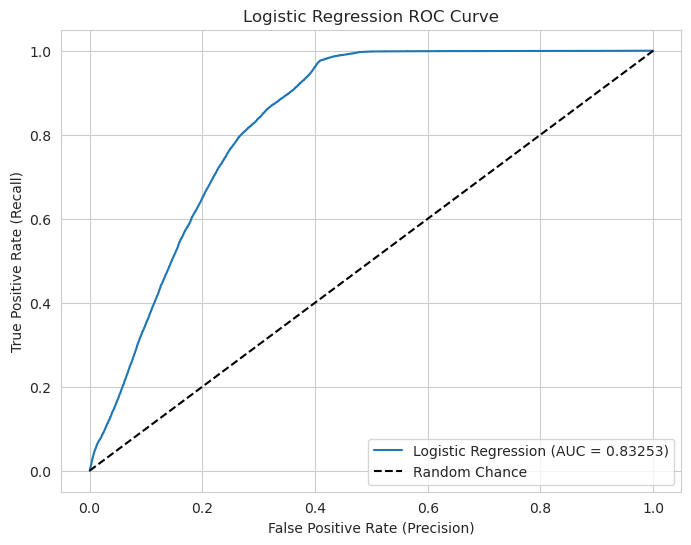

In [27]:
rfc_probs = GLM_fit.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, rfc_probs)
rfc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.5f})'.format(rfc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # Random chance line
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate (Precision)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.show()


In [28]:
predicted_labels = GLM_fit.predict(x_test) 
accuracy = 100*accuracy_score(y_test, predicted_labels)
#predicted_probs = GLM_fit.predict_proba(x_test)[:,1] 
roc_auc = 100*roc_auc_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
print("ROC-AUC Score:", roc_auc)

Accuracy: 76.21749134071484
ROC-AUC Score: 78.24441320011101


**Random Forest**

In [29]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)
rfc_pred = rfc.predict(x_test)
print(f"Accuracy score is {100*accuracy_score(y_test,rfc_pred)}\nROC-AUC score is {100*roc_auc_score(y_test,rfc_pred)}")

Accuracy score is 94.3999136148051
ROC-AUC score is 94.88305673124235


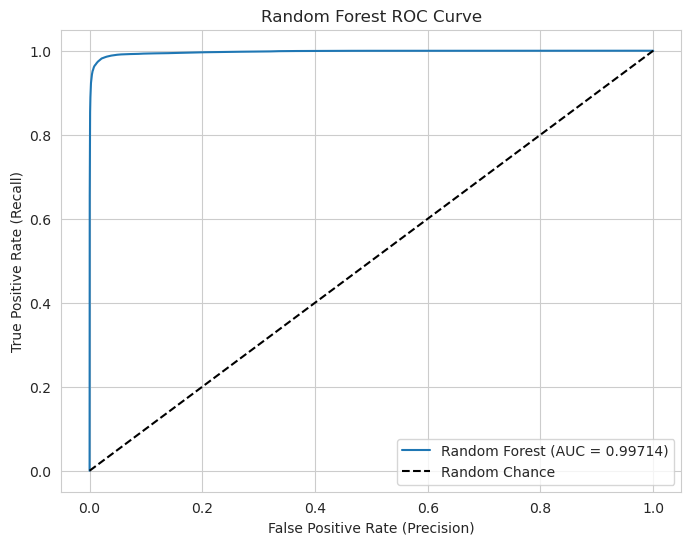

In [30]:
rfc_probs = rfc.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, rfc_probs)
rfc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.5f})'.format(rfc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # Random chance line
plt.title('Random Forest ROC Curve')
plt.xlabel('False Positive Rate (Precision)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.show()

**Decision Tree**

Accuracy: 0.93494
ROC-AUC Score: 0.94069


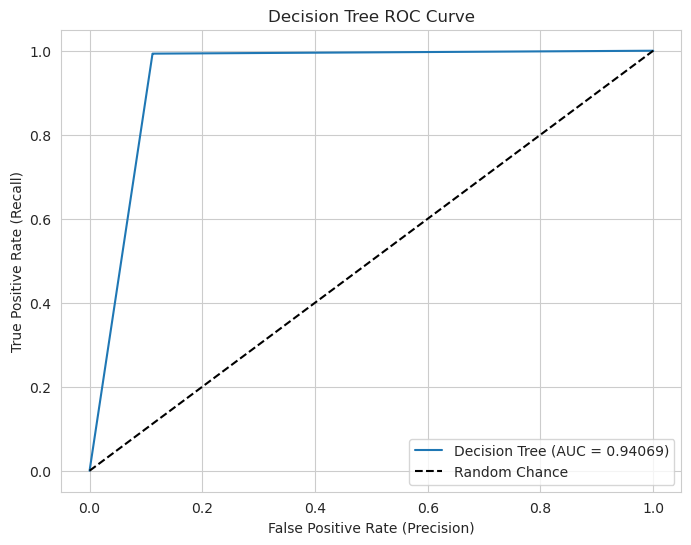

In [31]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

dtc_pred = dtc.predict(x_test)  
dtc_probs = dtc.predict_proba(x_test)[:, 1]  

dtc_accuracy = accuracy_score(y_test, dtc_pred)
print("Accuracy:", format(round(dtc_accuracy, 5)))

dtc_roc_auc = roc_auc_score(y_test, dtc_probs)
print("ROC-AUC Score:", format(round(dtc_roc_auc, 5)))

fpr, tpr, _ = roc_curve(y_test, dtc_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Decision Tree (AUC = {:.5f})'.format(dtc_roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance') 
plt.title('Decision Tree ROC Curve')
plt.xlabel('False Positive Rate (Precision)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.show()


**Conclusion**

The analysis reveals that among the evaluated models, Random Forest yields the highest performance, closely followed by Decision Trees and Logistic Regression. This insight underscores the potential of machine learning models, especially when integrated with domain-specific knowledge, to predict the likelihood of existing health insurance customers opting for vehicle insurance. To further refine our understanding and enhance predictive accuracy, exploring additional models on this dataset is a promising avenue, enabling us to ascertain the most effective model for this prediction task.


**References**

https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction/data

https://scikit-learn.org/stable/modules/tree.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
